In [1]:
import pandas as pd
from pathlib import Path
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.decomposition import PCA

from tqdm.notebook import tqdm
import time
pd.options.display.max_rows = 100

In [2]:
file_path = Path("./Recipe generator/data/recipes.csv")
df1 = pd.read_csv(file_path)

In [3]:
#dataset cleanup
df1.dropna(subset=['RecipeId', 'AggregatedRating'], axis=0, inplace=True)
# df1.shape

In [4]:
# pd.DataFrame(df1[df1["ReviewCount"]>100]["ReviewCount"].value_counts()).sort_values(by='ReviewCount')


In [5]:
# df=df.drop(df.index[100:])
# df = df1[df1["ReviewCount"]>20]
# len(df)


In [6]:
# pd.DataFrame(df1[df1["AggregatedRating"]>100]["ReviewCount"].value_counts()).sort_values(by='ReviewCount')
df2=df1["AggregatedRating"].value_counts()
df2
# df1["AggregatedRating"]=

AggregatedRating
5.0    174516
4.0     42829
4.5     34330
3.0      9166
3.5      3978
2.0      2049
1.0      1677
2.5       673
1.5        76
Name: count, dtype: int64

In [7]:
df2

AggregatedRating
5.0    174516
4.0     42829
4.5     34330
3.0      9166
3.5      3978
2.0      2049
1.0      1677
2.5       673
1.5        76
Name: count, dtype: int64

In [8]:
#sample "sample_size" recipes from each rating
import pandas as pd
import random, math
sample_size=1676

df_trunc=df1.iloc[[0]]
df_trunc.drop(index=0,inplace=True)
for j in tqdm(df2.index):
    if df2[j]>sample_size:
        # for k in tqdm(range(0,df2[df2>sample_size].min())):
        for k in tqdm(range(0,sample_size)):
            df_trunc = pd.concat([df_trunc, df1[df1["AggregatedRating"]==j].reset_index().iloc[[math.floor(random.random()*df2[j])]]])


/var/folders/vf/vmk7hfw95j1f6p8wn00dpk3m0000gn/T/ipykernel_82859/3658878438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_trunc.drop(index=0,inplace=True)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

  0%|          | 0/1676 [00:00<?, ?it/s]

In [9]:
df=df_trunc
df_trunc["AggregatedRating"].value_counts()

AggregatedRating
5.0    1676
4.0    1676
4.5    1676
3.0    1676
3.5    1676
2.0    1676
1.0    1676
Name: count, dtype: int64

In [10]:
ingredients=df["RecipeIngredientParts"]
keywords=df["Keywords"]

In [11]:
#splitting ingredients to separate columns
ingredients = ingredients.str.replace(" ", "\"")
temp =ingredients.str.split("\"",expand=True)
dummies=pd.get_dummies(temp,dtype=int)
dummies.columns=dummies.columns.str.lower()
s=dummies.columns.str.lstrip('0123456789_').str.lower()
s=s.to_frame().drop_duplicates()
# s.drop(s.index[0:4],inplace=True)
s.rename(columns={0:"ingredients list"},inplace=True)
s


,ingredients list
,
c(,c(
character(0),character(0)
%,%
absolut,absolut
...,...
homemade,homemade
bechamel,bechamel
nicoise,nicoise
chayote,chayote


In [12]:
#splitting keywords to separate columns
keywords = keywords.str.replace(" ", "\"")
temp =keywords.str.split("\"",expand=True)
dummiesk=pd.get_dummies(temp,dtype=int)
dummiesk.columns=dummiesk.columns.str.lower()
sk=dummiesk.columns.str.lstrip('0123456789_').str.lower()
sk=sk.to_frame().drop_duplicates()
# sk.drop(sk.index[0:4],inplace=True)
sk.rename(columns={0:"keywords list"},inplace=True)
sk

,keywords list
,
c(,c(
<,<
african,african
apple,apple
...,...
baking,baking
nigerian,nigerian
guatemalan,guatemalan
college,college


In [13]:
# creating dummy tables for all ingredients
#scanning every column for duplicate named columns
for j in tqdm(range(0,dummies.shape[1])):
    # progress counter
    # if j%100==0:
    #     print(j)
    col_idx_drop=[]

    #merging duplicate columns
    for k in range(j+1,dummies.shape[1]):
        #column duplicate name check
        if (dummies.columns[j].lstrip('0123456789_')==dummies.columns[k].lstrip('0123456789_')):
            #merging duplicate columns
            dummies.iloc[:,j] = dummies.iloc[:,j]+dummies.iloc[:,k]
            col_idx_drop.append(k)
    #dropping the second duplicate named column
    dummies.drop(columns=dummies.columns[col_idx_drop],inplace=True)

for j in range(0,dummies.shape[1]):
    dummies.rename(columns={dummies.columns[j]:dummies.columns[j].lstrip('0123456789_')},inplace=True)

  0%|          | 0/21732 [00:00<?, ?it/s]

In [14]:
#same rationale applied for keywords, as for ingredients
for j in tqdm(range(0,dummiesk.shape[1])):
    # if j%10000==0:
    #     print(j)
    col_idx_drop=[]
    
    for k in range(j+1,dummiesk.shape[1]):
        if (dummiesk.columns[j].lstrip('0123456789_')==dummiesk.columns[k].lstrip('0123456789_')):
            dummiesk.iloc[:,j] = dummiesk.iloc[:,j]+dummiesk.iloc[:,k]
            col_idx_drop.append(k)
  
    dummiesk.drop(columns=dummiesk.columns[col_idx_drop],inplace=True)

for j in range(0,dummiesk.shape[1]):
    dummiesk.rename(columns={dummiesk.columns[j]:dummiesk.columns[j].lstrip('0123456789_')},inplace=True)

  0%|          | 0/4103 [00:00<?, ?it/s]

In [15]:
#change to 1 every number greater than 1 on dummy table
dummies[dummies.iloc[:,:]>1]=1
dummiesk[dummiesk.iloc[:,:]>1]=1

#remove columes that are all 1
dummies = dummies.iloc[:,list(dummies.sum()<0.5*len(dummies))]
dummiesk = dummiesk.iloc[:,list(dummiesk.sum()<0.5*len(dummiesk))]

In [16]:
#create combined table and change the Rating column to int for the ML algorithm
df_combined = pd.concat([df['AggregatedRating'], dummies],axis=1)
df_combined["AggregatedRating"] = df_combined["AggregatedRating"]*2
df_combined.astype(int)

,AggregatedRating,character(0),%,-inch,absolut,amaretto,amarula,american,bacardi,baker's,...,barbeque,nan's,dumplings,puerto,rican,marinade,remoulade,sofrito,fresca,chocolate-covered
3800,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
126565,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
55151,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58362,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
123121,10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1310,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
417,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
#filter out single rows in df_combined
for x in df_combined["AggregatedRating"].sort_values().unique():
    if len(df_combined[df_combined["AggregatedRating"]==x])==1:
        df_combined.drop(index=df_combined[df_combined["AggregatedRating"]==x].index,inplace=True)

In [18]:
#export ingredient and keywords file for review
dummies.to_csv('dummies.csv',index=False)
dummiesk.to_csv('dummiesk.csv',index=False)

In [19]:
df_combined.drop(columns=df_combined.sum().sort_values(ascending=False)[1000:-1].index,inplace=True)
# df_combined.columns=["AggregatedRating", df_combined.sum().sort_values(ascending=False)[:400].index]

In [20]:
#export df_combined file for review
df_combined.to_csv('df_combined.csv',index=False)

In [21]:
pd.DataFrame(df_combined.sum()).sort_values(by=0,ascending=False)[:100]

,0
AggregatedRating,77096.0
salt,5032.0
sugar,4290.0
butter,3523.0
pepper,3334.0
flour,3321.0
garlic,3052.0
onion,2803.0
cheese,2646.0
water,2472.0


In [ ]:
X.drop(columns=['character(0)', '%', '-inch'],inplace=True)

In [243]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
X=df_combined.drop(columns='AggregatedRating')
y=df_combined['AggregatedRating']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=1, 
                                                    stratify=y)
classifier = LogisticRegression(solver='liblinear', random_state=1)
classifier.fit(X_train, y_train)
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")


Training Data Score: 0.3872030912603705
Testing Data Score: 0.19604500511421752


In [23]:
# Predict outcomes for test data set
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).to_csv('del.csv')


In [24]:
pd.DataFrame({"Prediction": predictions, "Actual": y_test}).corr()

,Prediction,Actual
Prediction,1.000000,0.111981
Actual,0.111981,1.000000


In [25]:
y[y==10]

3800      10.0
126565    10.0
55151     10.0
58362     10.0
123121    10.0
          ... 
110112    10.0
128426    10.0
167295    10.0
1266      10.0
89361     10.0
Name: AggregatedRating, Length: 1676, dtype: float64

In [26]:
from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.19604500511421752

In [253]:
# Instantiate the PCA instance and declare the number of PCA variables
pca=PCA(n_components=4)

df_pca = pca.fit_transform(X)

# Review the first 5 rows of the array of list data
# print(df_pca[:5])

# Calculate the PCA explained variance ratio
print(f"PCA variance sum: ({sum(pca.explained_variance_ratio_)}), PCA component variance: ({pca.explained_variance_ratio_})")

# Create the PCA DataFrame
df_pca = pd.DataFrame(
    df_pca
#     # columns=["PCA1", "PCA2", "PCA3"]
)

# # Review the PCA DataFrame
df_pca.head()

PCA variance sum: (0.17837024199925916), PCA component variance: ([0.08147977 0.04332825 0.0283194  0.02524282])


,0,1,2,3
0,-1.334268,0.065195,-0.548216,0.125819
1,0.270651,-0.620356,-0.404727,-0.074165
2,-0.220613,-0.359697,0.985116,-0.070512
3,-0.332150,-0.789470,-0.766643,-0.199943
4,-0.434017,-0.528531,-0.627885,0.526688


3800      10.0
126565    10.0
55151     10.0
58362     10.0
123121    10.0
          ... 
9          2.0
275        2.0
1310       2.0
417        2.0
27         2.0
Name: AggregatedRating, Length: 11732, dtype: float64

## Linear Regression

In [254]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
print(f"Model's slope: {model.coef_}")
print(f"Model's y-intercept: {model.intercept_}")
print(f"Model's formula: y = {model.intercept_} + {model.coef_[0]}X")

# Make predictions using the X set
predicted_y_values = pd.DataFrame(model.predict(X), columns=['predicted values'])
# Create a copy of the original data
df_sales_predicted = pd.concat([df_combined['AggregatedRating'].reset_index(),predicted_y_values],axis=1)

# Display sample data
df_sales_predicted.head()

Model's slope: [-3.63790679e-01 -2.77814018e-01  1.10847090e+00 -5.78026138e-01
  5.75514787e-01  3.09303535e-01  9.37381487e-02  2.75346502e+00
 -1.63010548e-01 -2.47239579e+00  5.50983398e-01 -1.25160731e+00
  1.02310876e+00 -1.09710921e+13  1.51233559e-01  2.37647498e+00
 -1.32872514e-01 -3.34974992e-01  1.30992091e+00  2.45311862e+00
 -1.39960395e+00  2.29832000e+00  4.50175826e+00  9.96894063e-01
  7.82694676e-01 -3.66986863e-01 -1.09710921e+13 -2.19200512e-01
  4.73518043e-01 -3.06756055e+00 -6.83242934e-01  4.40538376e-01
 -1.37495484e+00  1.66442871e-01 -5.36987305e-01  1.05590820e-02
  6.82373047e-02  2.16262817e-01 -5.93383789e-01  4.79537964e-01
  6.86416626e-01 -9.13085938e-02 -4.25048828e-01  6.44531250e-02
 -1.68112183e+00 -5.40191650e-01 -4.49958801e-01 -9.39277649e-01
  1.43025416e+13  5.27587891e-01  4.08264160e-01 -4.21112061e-01
  1.95103455e+00  4.69543457e-01 -1.79119587e-01  8.25729370e-02
  1.40979004e+00 -6.25854492e-01 -6.68487549e-01  7.03125000e-02
 -2.267608

,index,AggregatedRating,predicted values
0,3800,10.0,5.291308
1,126565,10.0,7.118647
2,55151,10.0,6.898493
3,58362,10.0,7.275433
4,123121,10.0,6.547350


In [269]:
print(X.shape, model.coef_.shape)
pd.DataFrame([X.columns, model.coef_, X.sum()]).T.to_csv('weight.csv')

(11732, 996) (996,)


In [268]:
X.sum()

character(0)         44
%                    72
-inch                 9
amaretto             24
american             34
                     ..
hickory               3
stout                 5
shoot                 4
bechamel              3
chocolate-covered     1
Length: 996, dtype: int64

In [29]:
model.coef_.shape

(996,)

In [242]:
df_sales_predicted.to_csv('result.csv')

In [246]:
# df_sales_predicted.drop(columns=['index'],inplace=True)
df_sales_predicted.dropna(inplace=True)
df_sales_predicted.drop(index=df_sales_predicted[df_sales_predicted['predicted values']<-100].index,inplace=True)
df_sales_predicted.drop(index=df_sales_predicted[df_sales_predicted['predicted values']>100].index,inplace=True)
df_sales_predicted


,index,AggregatedRating,predicted values
0,3800,10.0,7.609804
1,126565,10.0,6.733847
2,55151,10.0,7.375422
3,58362,10.0,6.531863
4,123121,10.0,7.501757
...,...,...,...
8794,2020,4.0,7.137728
8795,963,4.0,6.224512
8796,1100,4.0,4.861094
8797,1837,4.0,5.146731


In [248]:
df_sales_predicted['AggregatedRating'].unique()

array([10.,  8.,  9.,  6.,  7.,  4.])

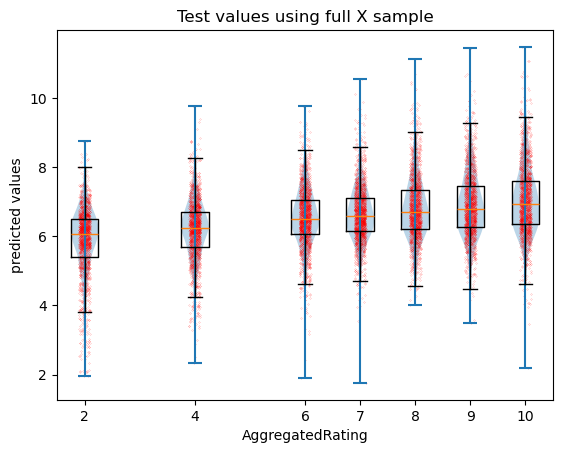

In [270]:
import matplotlib.pyplot as plt
# j=0
# data=[]
# for i in df_sales_predicted['AggregatedRating'].unique():
#     data[j]=pd.concat([data, df_sales_predicted[df_sales_predicted['AggregatedRating']==i]['predicted values']],axis=0)
#     j+=1

plt.violinplot([df_sales_predicted[df_sales_predicted['AggregatedRating']==2]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==4]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==6]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==7]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==8]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==9]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==10]['predicted values']], positions=[2, 4, 6, 7, 8, 9, 10])
plt.boxplot([df_sales_predicted[df_sales_predicted['AggregatedRating']==2]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==4]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==6]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==7]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==8]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==9]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==10]['predicted values']], positions=[2, 4, 6, 7, 8, 9, 10],
            flierprops={'marker': 'o', 'markersize': 0, 'markeredgecolor': 'red'} )
plt.scatter(df_sales_predicted['AggregatedRating']+0.2*random.rand(len(df_sales_predicted['AggregatedRating']),1).ravel()-.1,
            df_sales_predicted['predicted values'],marker='o',s=.01,c='r')
plt.xlabel("AggregatedRating")
plt.ylabel("predicted values")
plt.title('Test values using full X sample')
plt.show()

In [159]:
from numpy import random

random.rand(len(df_sales_predicted['AggregatedRating']),1)

array([[0.47894295],
       [0.76290316],
       [0.41381329],
       ...,
       [0.3729936 ],
       [0.9180169 ],
       [0.41542136]])

In [176]:
df_sales_predicted['AggregatedRating']
random.rand(len(df_sales_predicted['AggregatedRating']),1).ravel().reshape(-1,1)

array([[0.33389611],
       [0.44823512],
       [0.82526998],
       ...,
       [0.10904758],
       [0.92051898],
       [0.02101675]])

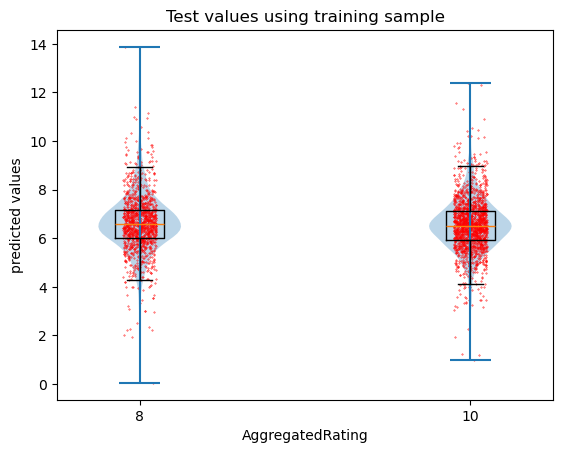

In [220]:

plt.violinplot([df_sales_predicted[df_sales_predicted['AggregatedRating']==8]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==10]['predicted values']], positions=[8, 10])
plt.boxplot([df_sales_predicted[df_sales_predicted['AggregatedRating']==8]['predicted values'],
            df_sales_predicted[df_sales_predicted['AggregatedRating']==10]['predicted values']],  positions=[8, 10],
            flierprops={'marker': 'o', 'markersize': 0, 'markeredgecolor': 'red'} )
plt.xlabel("AggregatedRating")
plt.ylabel("predicted values")
plt.scatter(df_sales_predicted['AggregatedRating']+0.2*random.rand(len(df_sales_predicted['AggregatedRating']),1).ravel()-.1,
            df_sales_predicted['predicted values'],marker='o',s=.11,c='r')
plt.title('Test values using training sample')
plt.show()

In [83]:
df_sales_predicted[df_sales_predicted['AggregatedRating']==10]['predicted values']

0       5.258085
1       7.109828
2       6.892204
3       7.292039
4       6.537104
          ...   
1671    5.000378
1672    8.586219
1673    6.110495
1674    7.036670
1675    8.570919
Name: predicted values, Length: 1676, dtype: float64

## Dimensionality reduction